In [525]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse
import scipy.sparse.linalg
import numpy.linalg 
from scipy.sparse import random, csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
import os
import ssgetpy
from PIL import Image
import requests
from io import BytesIO
import scipy
import scipy.io
import time
import scipy.linalg 
from scipy import stats
from numpy.random import default_rng
from collections import namedtuple
%matplotlib inline

In [526]:
def roll(A, p, r, P):
    A[:, [p, r-1]] = A[:, [r-1,p]]
    P[[p, r-1]] = P[[r-1, p]]
    for i in range(p, r - 2):
        A[:,[i, i + 1]] = A[:,[i + 1,i]]
        P[[i,i + 1]] = P[[i + 1, i]]
    return P

### Sparse Bartels-Golub Method

In [596]:
def UR(A, p, r):
    for i in range(p, r):
        if A[i, i] == 0:
            A[[i+1, i], :] = A[[i, i+1], :]
        else:
            A[i+1, i:] -= A[i, i:] * (A[i+1, i] / A[i, i])
    return A

def LU_BG(A, q, k):
    P = np.arange(A.shape[1])
    Q = np.arange(A.shape[0])
    A[:, k] = q
    r = A.shape[0] - 1
    for i in range(A.shape[0]-1, -1, -1):
        if(A[i,k] != 0):
            r = i
            break
    P = roll(A, k, r, P)
    return UR(A, k, r), P, Q

### Forrest-Tomlin Method

In [597]:
def UFT(A, p):
    for i in range(p, A.shape[0]-1):
        if A[A.shape[0]-1,i] == 0:
            continue
        if A[i, i] == 0:
            A[[i, A.shape[0]-1], :] = A[[A.shape[0]-1, i], :]
        else:
            A[A.shape[0]-1, i:] -= A[i, i:] * (A[A.shape[0]-1, i] / A[i, i])
    return A

def LU_FT(A, q, k):
    P = np.arange(A.shape[1])
    Q = np.arange(A.shape[0])
    A[:,k] = q
    P = roll(A, k, A.shape[0]-1,P)
    B = A.T
    Q = roll(B, k, B.shape[1],Q)
    A = B.T
    return UFT(A, k), P, Q

### Suhl Method

In [598]:
def US(A, p, r, Q):
    for i in range(p, r):
        A[p, i:] -= A[i+1, i:] * (A[p, i] / A[i+1, i])
    B = A.T
    roll(B, p, r + 1, Q)
    C = B.T
    return C, Q

def LU_ST(A, q, k):
    P = np.arange(A.shape[1])
    Q = np.arange(A.shape[0])
    A[:, k] = q
    r = A.shape[0] - 1
    for i in range(A.shape[0]-1, -1, -1):
        if(A[i,k] != 0):
            r = i
            break
    P = roll(A, k, r, P)
    C, Q = US(A, k, r, Q)
    return C, P, Q

In [599]:
Metrics = namedtuple('Metrics', ['time', 'nnz_ratio', 'nnz_boost'])

In [625]:
dim = 100
ratio = 0.5

LP_name = ""


MODE = "random_gauss" # "LP"

In [626]:
def generate_sparse_matrix(MODE, LP_name=None, dim=None, ratio=None):
    
    if MODE == "random_gauss":
        A = csc_matrix(scipy.sparse.random(dim, dim, density=ratio, random_state=rng, data_rvs=Y.rvs), dtype=float)
        A = A + scipy.sparse.csr_matrix(np.eye(A.shape[0]) * 1e-8)
        current_sparse_matrix = scipy.sparse.csc_matrix(A).A

    elif MODE == "LP":
        matrix_file = ssgetpy.search(LP_name)[0]
        print(f" LP Problem: {LP_name}; Shape: ({matrix_file.rows}, {matrix_file.cols}); NNZ: {matrix_file.nnz}")
        dest_path, _ = matrix_file.download(destpath='current', extract=True)
        with open(dest_path + '\\' + os.listdir(dest_path)[0]) as mass_file:
            otpt = scipy.io.mmread(mass_file)
            current_sparse_matrix = otpt.A
        response = requests.get(matrix_file.icon_url())
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
    return current_sparse_matrix

In [635]:
def calculate_metrics(sparse_matrix, pos, vec, method="BG", time_iters=1):
    P_scipy, L_scipy, U_scipy = scipy.linalg.lu(sparse_matrix)

    sparse_matrix_mod = sparse_matrix.copy()
    sparse_matrix_mod[:, pos] = vec
    q = scipy.linalg.inv(P_scipy @ L_scipy) @ vec
    
    computation_time_list = []
    for it in range(time_iters):
        U_scipy_copy = U_scipy.copy()
        
        begin_comp = time.process_time()
        if method == "BG":
            U_updated, P_updated, Q_updated = LU_BG(U_scipy_copy, q, pos)
        elif method == "FT":
            U_updated, P_updated, Q_updated = LU_FT(U_scipy_copy, q, pos)
        elif method == "ST":
            U_updated, P_updated, Q_updated = LU_ST(U_scipy_copy, q, pos)
        else:
            raise NotImplementedError
            
        end_comp = time.process_time()
        computation_time_list.append(end_comp - begin_comp)
    computation_time = np.sum(computation_time_list)

    P_new, L_new, U_new = scipy.linalg.lu(sparse_matrix_mod)

    L_updated = scipy.linalg.inv(P_scipy) @ sparse_matrix_mod[:, P_updated][Q_updated] @ scipy.linalg.inv(U_updated)

#     if not np.allclose(L_updated, np.tril(L_updated)):
#         raise

    return Metrics(computation_time, np.sum(U_updated != 0) / (U_updated.shape[0] * U_updated.shape[1]),\
                (np.sum(U_updated != 0) -  np.sum(U_new != 0)) / (U_updated.shape[0] * U_updated.shape[1]))

In [636]:
calculate_metrics(current_sparse_matrix, pos=0, vec=np.ones(current_sparse_matrix.shape[0]))

Metrics(time=0.0, nnz_ratio=0.3949, nnz_boost=-0.0026)

In [676]:
pos_vec_iters = 1
dim_values = [100, 150, 300, 500, 1000, 2500, 5000]
ratio_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

In [677]:
time_dict = {method: [] for method in ["BG", "FT", "ST"]}
nnz_ratio_dict = {method: [] for method in ["BG", "FT", "ST"]}
nnz_boost_dict = {method: [] for method in ["BG", "FT", "ST"]}

r = 0.3
for n in dim_values:
    current_sparse_matrix = generate_sparse_matrix("random_gauss", dim=n, ratio=r)
    time_pos_vec, nnz_ratio_pos_vec, nnz_boost_pos_vec = {method: [] for method in ["BG", "FT", "ST"]},\
                                                         {method: [] for method in ["BG", "FT", "ST"]},\
                                                         {method: [] for method in ["BG", "FT", "ST"]}
    for _ in range(pos_vec_iters):
        pos = int(np.random.uniform(0, current_sparse_matrix.shape[1], 1)[0])
        vec = np.random.normal(0, 1, current_sparse_matrix.shape[0])
        for method in ["BG", "FT", "ST"]:
            metrics = calculate_metrics(current_sparse_matrix.copy(), method=method, pos=pos, vec=vec)
            time_pos_vec[method].append(metrics.time)
            nnz_ratio_pos_vec[method].append(metrics.nnz_ratio)
            nnz_boost_pos_vec[method].append(metrics.nnz_boost)
    
    for method in ["BG", "FT", "ST"]:
        time_dict[method].append(np.max(time_pos_vec[method]))
        nnz_ratio_dict[method].append(np.max(nnz_ratio_pos_vec[method]))
        nnz_boost_dict[method].append(np.max(nnz_boost_pos_vec[method]))

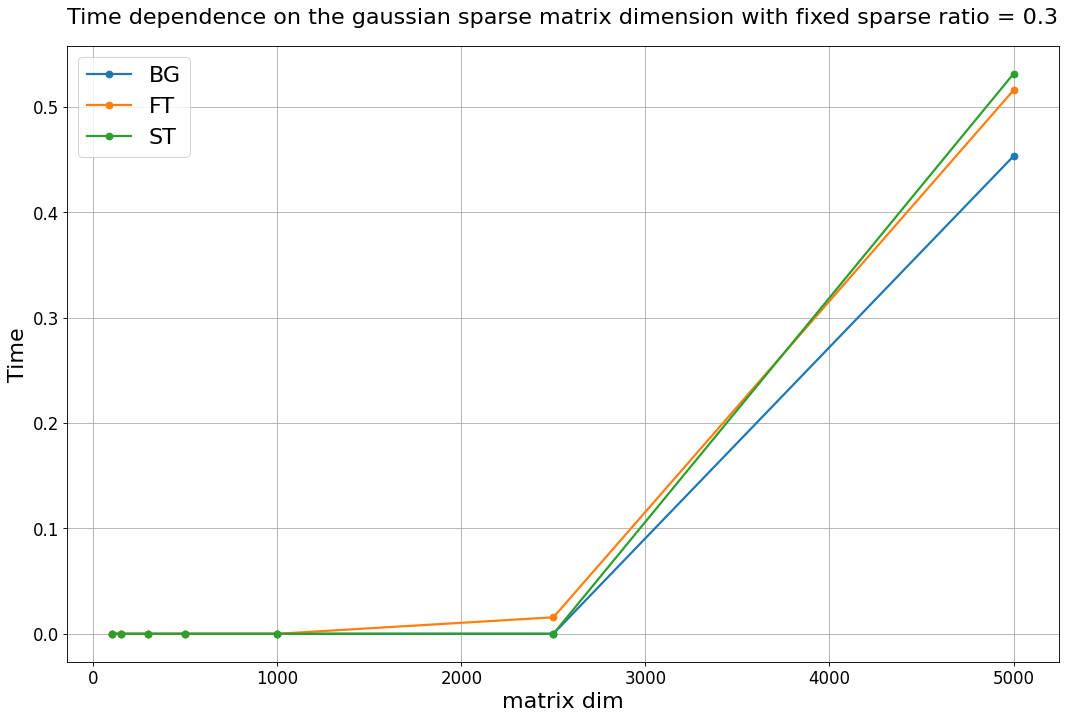

In [683]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
for method in ["BG", "FT", "ST"]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(dim_values, time_dict[method], linewidth=2, marker='o', color=color,
                                                    label=f'{method}')
plt.legend(loc="upper left", fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.title(f"Time dependence on the gaussian sparse matrix dimension with fixed sparse ratio = {r}", fontsize=20, pad=20)
ax.set_xlabel('matrix dim', fontsize=20)
ax.set_ylabel('Time', fontsize=20)
plt.grid(True)

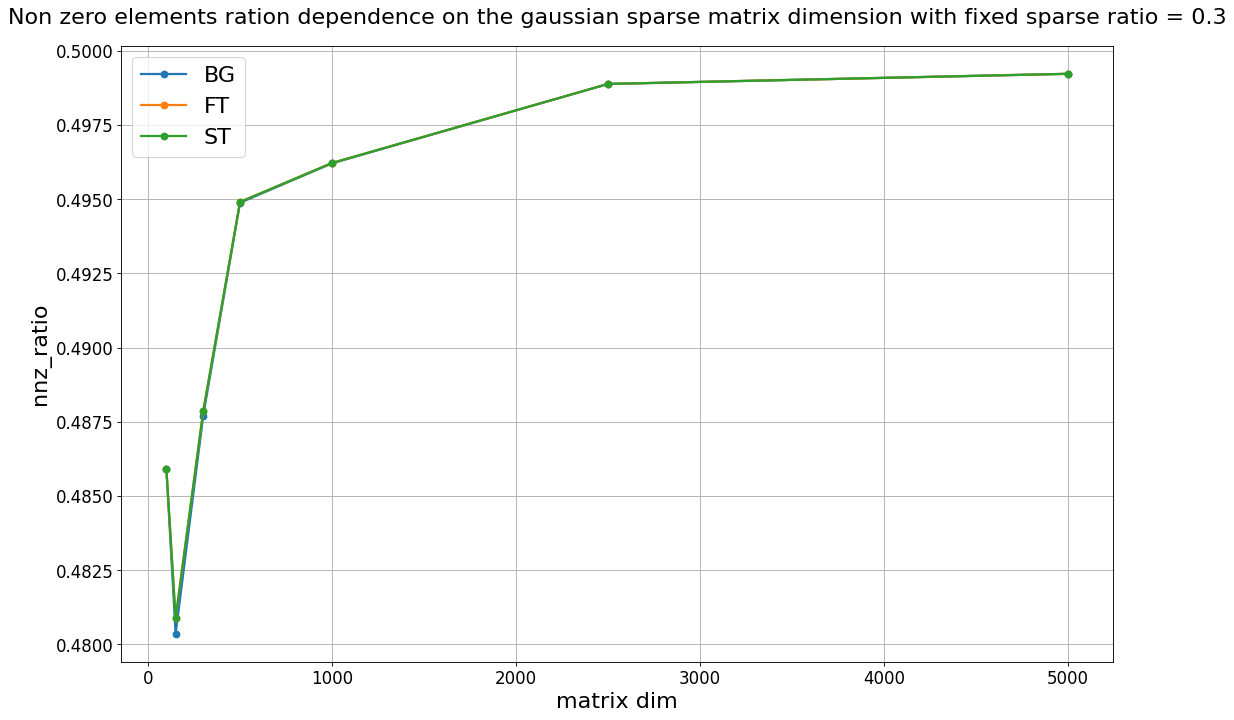

In [684]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
for method in ["BG", "FT", "ST"]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(dim_values, nnz_ratio_dict[method], linewidth=2, marker='o', color=color,
                                                      label=f'{method}')
plt.legend(loc="upper left", fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.title(f"Non zero elements ration dependence on the gaussian sparse matrix dimension with fixed sparse ratio = {r}", fontsize=20, pad=20)
ax.set_xlabel('matrix dim', fontsize=20)
ax.set_ylabel('nnz_ratio', fontsize=20)
plt.grid(True)

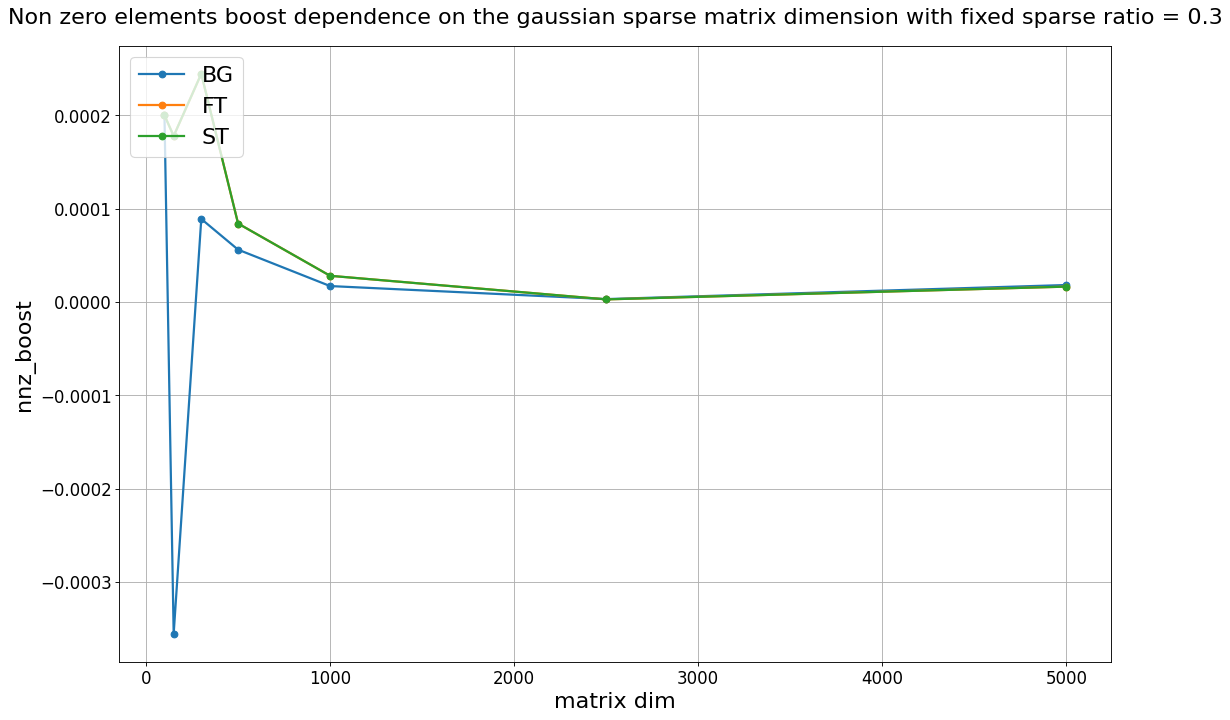

In [685]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
for method in ["BG", "FT", "ST"]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(dim_values, nnz_boost_dict[method], linewidth=2, marker='o', color=color,
                                                     label=f'{method}')
plt.legend(loc="upper left", fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.title(f"Non zero elements boost dependence on the gaussian sparse matrix dimension with fixed sparse ratio = {r}", fontsize=20, pad=20)
ax.set_xlabel('matrix dim', fontsize=20)
ax.set_ylabel('nnz_boost', fontsize=20)
plt.grid(True)

In [687]:
time_dict = {method: [] for method in ["BG", "FT", "ST"]}
nnz_ratio_dict = {method: [] for method in ["BG", "FT", "ST"]}
nnz_boost_dict = {method: [] for method in ["BG", "FT", "ST"]}

n = 2000
for r in ratio_values:
    current_sparse_matrix = generate_sparse_matrix("random_gauss", dim=n, ratio=r)
    time_pos_vec, nnz_ratio_pos_vec, nnz_boost_pos_vec = {method: [] for method in ["BG", "FT", "ST"]},\
                                                         {method: [] for method in ["BG", "FT", "ST"]},\
                                                         {method: [] for method in ["BG", "FT", "ST"]}
    for _ in range(pos_vec_iters):
        pos = int(np.random.uniform(0, current_sparse_matrix.shape[1], 1)[0])
        vec = np.random.normal(0, 1, current_sparse_matrix.shape[0])
        for method in ["BG", "FT", "ST"]:
            metrics = calculate_metrics(current_sparse_matrix.copy(), method=method, pos=pos, vec=vec)
            time_pos_vec[method].append(metrics.time)
            nnz_ratio_pos_vec[method].append(metrics.nnz_ratio)
            nnz_boost_pos_vec[method].append(metrics.nnz_boost)
            
    for method in ["BG", "FT", "ST"]:
        time_dict[method].append(np.max(time_pos_vec[method]))
        nnz_ratio_dict[method].append(np.max(nnz_ratio_pos_vec[method]))
        nnz_boost_dict[method].append(np.max(nnz_boost_pos_vec[method]))

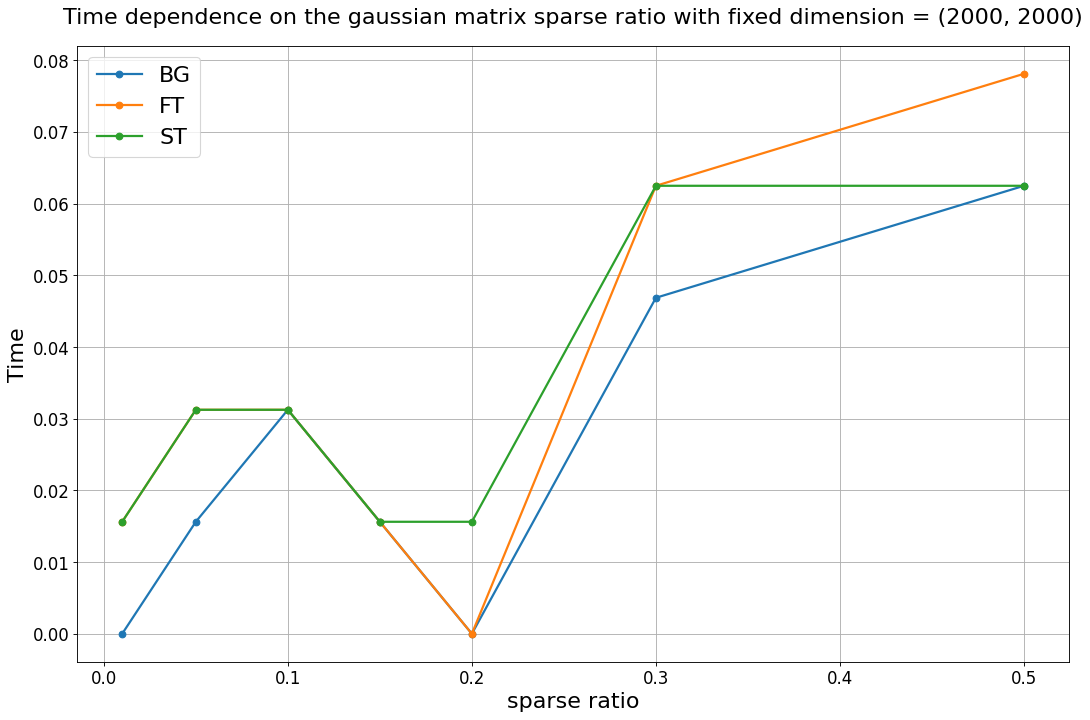

In [688]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
for method in ["BG", "FT", "ST"]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ratio_values, time_dict[method], linewidth=2, marker='o', color=color,
                                                    label=f'{method}')
plt.legend(loc="upper left", fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.title(f"Time dependence on the gaussian matrix sparse ratio with fixed dimension = ({n}, {n})", fontsize=20, pad=20)
ax.set_xlabel('sparse ratio', fontsize=20)
ax.set_ylabel('Time', fontsize=20)
plt.grid(True)

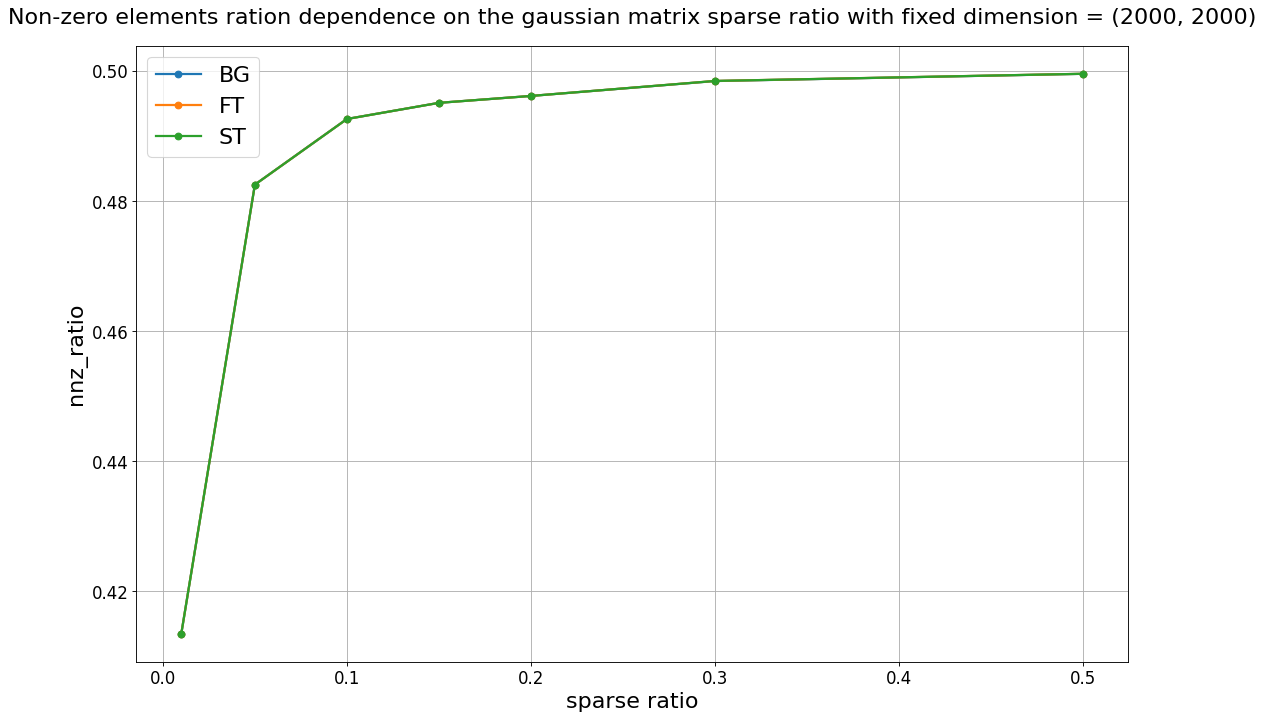

In [691]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
for method in ["BG", "FT", "ST"]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ratio_values, nnz_ratio_dict[method], linewidth=2, marker='o', color=color,
                                                    label=f'{method}')
plt.legend(loc="upper left", fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.title(f"Non-zero elements ration dependence on the gaussian matrix sparse ratio with fixed dimension = ({n}, {n})", fontsize=20, pad=20)
ax.set_xlabel('sparse ratio', fontsize=20)
ax.set_ylabel('nnz_ratio', fontsize=20)
plt.grid(True)

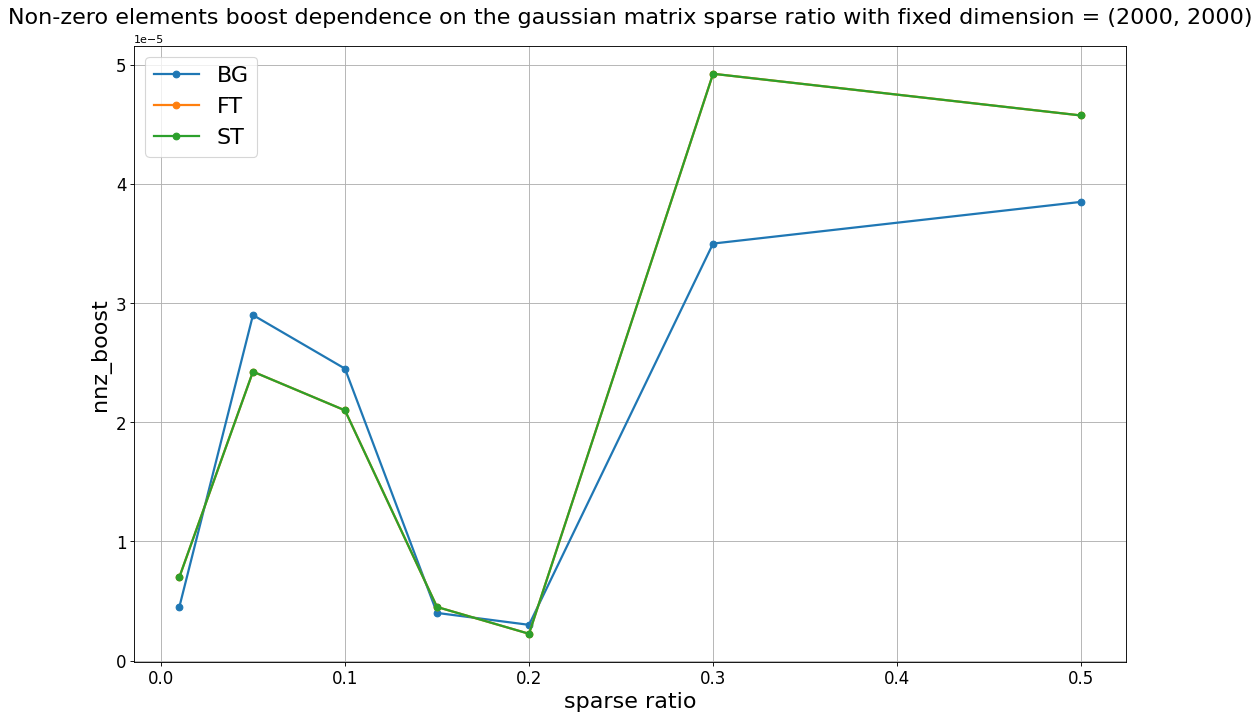

In [692]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
for method in ["BG", "FT", "ST"]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ratio_values, nnz_boost_dict[method], linewidth=2, marker='o', color=color,
                                                    label=f'{method}')
plt.legend(loc="upper left", fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.title(f"Non-zero elements boost dependence on the gaussian matrix sparse ratio with fixed dimension = ({n}, {n})", fontsize=20, pad=20)
ax.set_xlabel('sparse ratio', fontsize=20)
ax.set_ylabel('nnz_boost', fontsize=20)
plt.grid(True)

In [725]:
for el in ssgetpy.search(kind="Optimization"):
    print(el)

(82, 'HB', 'bp_0', 822, 822, 3276, 'real', False, False, 0.00916030534351145, 0.001221374045801527, 'optimization problem sequence', 'https://sparse.tamu.edu/files/HB/bp_0.png')
(83, 'HB', 'bp_1000', 822, 822, 4661, 'real', False, False, 0.009448142581060769, 0.0004294610264118531, 'subsequent optimization problem', 'https://sparse.tamu.edu/files/HB/bp_1000.png')
(84, 'HB', 'bp_1200', 822, 822, 4726, 'real', False, False, 0.009322033898305085, 0.000423728813559322, 'subsequent optimization problem', 'https://sparse.tamu.edu/files/HB/bp_1200.png')
(85, 'HB', 'bp_1400', 822, 822, 4790, 'real', False, False, 0.01044932079414838, 0.0004179728317659352, 'subsequent optimization problem', 'https://sparse.tamu.edu/files/HB/bp_1400.png')
(86, 'HB', 'bp_1600', 822, 822, 4841, 'real', False, False, 0.01075491209927611, 0.0004136504653567735, 'subsequent optimization problem', 'https://sparse.tamu.edu/files/HB/bp_1600.png')
(87, 'HB', 'bp_200', 822, 822, 3802, 'real', False, False, 0.006315789473

In [726]:
LP_problems = ["bp_1000"] #, "25fv47", "degen3", "stocfor3", "80bau3b", "greenbeb", 
             #  "fit2d", "fit2p", "truss", "d2q06c", "pilots", "pilot87"]

 LP Problem: bp_1000; Shape: (822, 822); NNZ: 4661


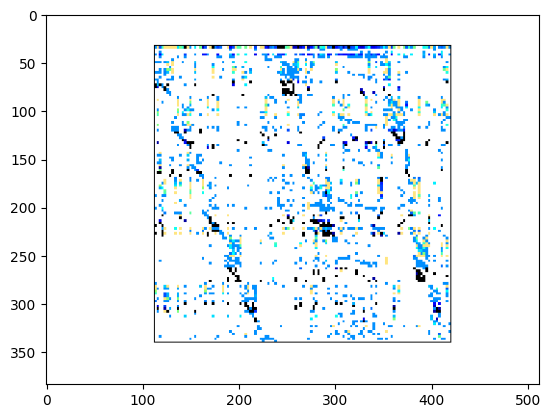

In [735]:
time_dict = {(method, problem): 0 for method in ["BG", "FT", "ST"] for problem in LP_problems}
nnz_ratio_dict = {(method, problem): 0 for method in ["BG", "FT", "ST"] for problem in LP_problems}
nnz_boost_dict = {(method, problem): 0 for method in ["BG", "FT", "ST"] for problem in LP_problems}


for problem in LP_problems:
    current_sparse_matrix = generate_sparse_matrix("LP", LP_name=problem)
    if current_sparse_matrix.shape[0] != current_sparse_matrix.shape[1]:
        m = min(current_sparse_matrix.shape[0], current_sparse_matrix.shape[1])
        current_sparse_matrix = current_sparse_matrix[:m, :m]
    time_pos_vec, nnz_ratio_pos_vec, nnz_boost_pos_vec = {method: [] for method in ["BG", "FT", "ST"]},\
                                                         {method: [] for method in ["BG", "FT", "ST"]},\
                                                         {method: [] for method in ["BG", "FT", "ST"]}
    for _ in range(pos_vec_iters):
        pos = int(np.random.uniform(0, current_sparse_matrix.shape[1], 1)[0])
        vec = np.random.normal(0, 1, current_sparse_matrix.shape[0])
        for method in ["BG", "FT", "ST"]:
            metrics = calculate_metrics(current_sparse_matrix.copy(), method=method, pos=pos, vec=vec)
            time_pos_vec[method].append(metrics.time)
            nnz_ratio_pos_vec[method].append(metrics.nnz_ratio)
            nnz_boost_pos_vec[method].append(metrics.nnz_boost)

    for method in ["BG", "FT", "ST"]:
        time_dict[(method, problem)] = np.max(time_pos_vec[method])
        nnz_ratio_dict[(method, problem)] = np.max(nnz_ratio_pos_vec[method])
        nnz_boost_dict[(method, problem)] = np.max(nnz_boost_pos_vec[method])

In [736]:
time_dict

{('BG', 'bp_1000'): 0.015625,
 ('FT', 'bp_1000'): 0.015625,
 ('ST', 'bp_1000'): 0.0}

In [737]:
nnz_ratio_dict

{('BG', 'bp_1000'): 0.05606170931974118,
 ('FT', 'bp_1000'): 0.0308309801623244,
 ('ST', 'bp_1000'): 0.0308309801623244}

In [738]:
nnz_boost_dict

{('BG', 'bp_1000'): 0.006658437968044234,
 ('FT', 'bp_1000'): -0.018572291189372547,
 ('ST', 'bp_1000'): -0.018572291189372547}